In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib notebook

In [75]:
url = "https://raw.githubusercontent.com/ga-students/SF-DAT-20/master/Data/myopia.csv"
MyopiaData = pd.read_csv(url)

In [3]:
MyopiaData.head()

,ID,STUDYYEAR,MYOPIC,AGE,GENDER,SPHEQ,AL,ACD,LT,VCD,SPORTHR,READHR,COMPHR,STUDYHR,TVHR,DIOPTERHR,MOMMY,DADMY
0,1,1992,1,6,1,-0.052,21.89,3.690,3.498,14.70,45,8,0,0,10,34,1,1
1,2,1995,0,6,1,0.608,22.38,3.702,3.392,15.29,4,0,1,1,7,12,1,1
2,3,1991,0,6,1,1.179,22.49,3.462,3.514,15.52,14,0,2,0,10,14,0,0
3,4,1990,1,6,1,0.525,22.20,3.862,3.612,14.73,18,11,0,0,4,37,0,1
4,5,1995,0,5,0,0.697,23.29,3.676,3.454,16.16,14,0,0,0,4,4,1,0


Here is our dataset dictionary: https://www.umass.edu/statdata/statdata/data/myopia.pdf

#### We are interested in finding out what contributes to Myopia the most. My grandmother always told me not to watch TV, play with computer since it will affect my eyes. (She was strangely fine with studying!). It sounds like Drs share the same point of view with my grandmother " http://www.allaboutvision.com/conditions/myopia.htm "

#### We are DataScientist and don't trust our grandmothers or DRs unless we find the same result! Now, let's go and explore Myopia!




In [76]:
# Year of study and id should not affect anything so we disregard them in this study. 
# we consider two types of inputs - first all general inputs - i.e. physical and external inputs
# second only external inputs
X1 = MyopiaData[['SPHEQ','AL','ACD','LT','VCD','AGE','GENDER','SPORTHR','READHR','COMPHR','STUDYHR','TVHR','DIOPTERHR','MOMMY','DADMY']]
X2 = MyopiaData[['AGE','GENDER','SPORTHR','READHR','COMPHR','STUDYHR','TVHR','DIOPTERHR','MOMMY','DADMY']]
y = MyopiaData['MYOPIC']


Run your regression line on X1 and interpret your MOMMY AND DADMY coefficients.

In [77]:
lm = LogisticRegression()
lm.fit(X1, y)
print lm.coef_

[[-3.39425428  0.11608585  0.77257154 -0.31202032 -0.32603761  0.00379027
   0.53625119 -0.04739567  0.09764203  0.05015869 -0.13224771 -0.00438641
  -0.00788606  0.63899595  0.72678877]]


Interpretation: it seems that SPHEQ is relevant as well as Gender, Mommy and Daddy, and ACD

#### Use confusion matrix and estimate False negative rate and False positive rate

In [94]:
lm.fit(X1, y)
y_hat = lm.predict(X1)
cm = confusion_matrix(y_hat, y)
print cm

[[524  53]
 [ 13  28]]


In [91]:
fpr = float(cm[0][1])/(cm[0][1] + cm[1][1]) 
fnr = float(cm[1][0])/(cm[0][0] + cm[1][0])
print fpr
print fnr
print cm

0.654320987654
0.024208566108
[[524  53]
 [ 13  28]]


#### Use 10-fold cross-validation to measure accuracy of your predictions

In [10]:
print(cross_val_score(lm,X1,y,cv=10).mean()) 



0.886747164933


#### In your dataset, what percentage of cases are myopic?

In [73]:
print float(len(y_hat[y_hat == 1]))/len(y_hat)
MyopiaData["MYOPIC"].mean()
#It seems 6.634 percent are myopic in my case

0.0550161812298


0.13106796116504854

#### Based on the result you found above, is your prediction precision good or bad?

Answer: IT seems my Prediction precision is bad. as there are 13% of cases found in my dataset

#### Imagine you would like to decrease your False negative rate. What can you do in order to make it less than 2%? 

In [83]:
def PredictThreshold(Predictprob,Threshhold):
    y_predict = 0
    if (Predictprob >= Threshhold):
        y_predict = 1
    return y_predict

def Fpr(cm):
    return float(cm[0][1])/(cm[0][1] + cm[1][1]) 

def Fnr(cm):
    return float(cm[1][0])/(cm[0][0] + cm[1][0])

y_hat_prob = lm.predict_proba(X1).T[1]
thresh = 0.06
y_hat_list = []
for i in range(0, len(y_hat_prob)):
    y_hat_list.append(PredictThreshold(y_hat_prob[i], thresh))
    
cm = confusion_matrix(y_hat_list, y)
print cm
print Fpr(cm)
print Fnr(cm)

[[324   4]
 [213  77]]
0.0493827160494
0.396648044693


Answer: 

#### Now let's run a logistic regression line on X2 and see if we can confirm our Grandmothers' claims!

In [70]:
lm.fit(X2, y)
print lm.coef_
print X2.columns.values



[[  3.62008409e-02   2.79789935e-01  -4.46768607e-02   7.27860411e-02
    1.29525220e-02  -8.53623896e-02  -5.81167570e-05   5.76482063e-03
    7.68034486e-01   8.95136625e-01]]
['AGE' 'GENDER' 'SPORTHR' 'READHR' 'COMPHR' 'STUDYHR' 'TVHR' 'DIOPTERHR'
 'MOMMY' 'DADMY']


array([537,  81])

Interpret your results specifically on StudyHr, TVH, and COMPHR, Gender: 

for each additional StudyHR the odds of Myopia go down, TVhr as well, and Computer hour is a very small indicator 

#### Now it's time for regularization and choosing the best predictors:

In [43]:
#Let's first standardize our data - use X1
def Standardize(X):
    X_Max = X.max()
    X_Min = X.min()
    X_Standardized = (X-X_Min)/(X_Max - X_Min)
    return X_Standardized

for i in X1.columns.values:
    MyopiaData[i] = Standardize(MyopiaData[i])



<IPython.core.display.Javascript object>


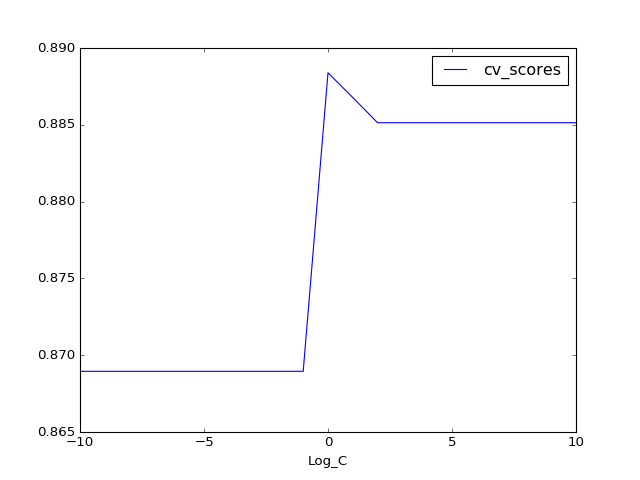

In [57]:
# Try testing and plot using different C as input and l1 penalty
c_list = np.logspace(-10, 10, 21)
c_index = np.linspace(-10, 10, 21)
X1 = MyopiaData[['SPHEQ','AL','ACD','LT','VCD','AGE','GENDER','SPORTHR','READHR','COMPHR','STUDYHR','TVHR','DIOPTERHR','MOMMY','DADMY']]
cv_scores = []
for c_score in c_list:
    lm = LogisticRegression(C = c_score, penalty = "l1")
    cv_scores.append(cross_val_score(lm, X1, y, cv=10).mean())

C_choice_df = pd.DataFrame({"cv_scores" : cv_scores, 'Log_C' : c_index})
C_choice_df.plot(x = "Log_C" , y ="cv_scores")

In [58]:
# localize your search around the maximum value you found earlier
lm = LogisticRegression(C = 10**(0.1), penalty="l1")
lm.fit(X1, y)

LogisticRegression(C=1.25892541179, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [59]:
# List your variables from the smallest to the largets
sorted(zip(lm.coef_[0], X1.columns.values))

[(-15.399677724952987, 'SPHEQ'),
 (-1.409801983768399, 'SPORTHR'),
 (-0.88927048964279942, 'STUDYHR'),
 (-0.06212310853328433, 'VCD'),
 (0.0, 'AGE'),
 (0.0, 'AL'),
 (0.0, 'COMPHR'),
 (0.0, 'DIOPTERHR'),
 (0.0, 'LT'),
 (0.0, 'TVHR'),
 (0.57082504199992523, 'GENDER'),
 (0.66565232623694526, 'MOMMY'),
 (0.71476102981457801, 'READHR'),
 (0.80999678446493883, 'DADMY'),
 (1.3173945855155949, 'ACD')]

#### What is your conclusions about your Grandmothers' and some other Drs' claims?

Answer: ACD, DADMY, READINGHOUR! MOMY, GENDER are by far the highest predictors of Myopia, the next variable, a good ways away is actually Reading :(

#### Draw ROC curve for your best tuned model. 

In [65]:
from sklearn.metrics import roc_curve, auc,roc_auc_score
y_hat_probability = lm.predict_proba(X1).T[1]
print(roc_auc_score(y, lm.predict_proba(X1).T[1]))
vals = roc_curve(y, y_hat_probability)  #an excellent value!

0.893142055774


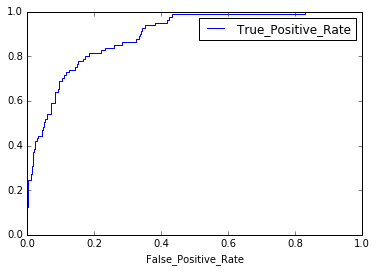

In [66]:
import matplotlib.pyplot as plt
%matplotlib inline
Roc_DataFrame = pd.DataFrame({'False_Positive_Rate':vals[0],'True_Positive_Rate':vals[1]})
Roc_DataFrame.plot(x = 'False_Positive_Rate' , y = 'True_Positive_Rate' ) #beautiful Graph